
1. BUSINESS UNDERSTANDING & DATA LOADING
Goal: Predict customer churn to improve retention.
Success Criteria: Accuracy > 80%.

✅ Dataset Loaded Locally: 7043 records

2. DATA PREPARATION
Challenges: 'TotalCharges' was text; categorical variables needed encoding.
Solution: Coerced errors to numbers, filled missing values, applied One-Hot Encoding.

✅ Data Processed & Scaled (80% Train / 20% Test).

3. DATA UNDERSTANDING (VISUALIZATION)


/tmp/ipython-input-3060049777.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace=True)
/tmp/ipython-input-3060049777.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Churn'], palette='pastel')


✅ Saved: 1_Distribution.svg


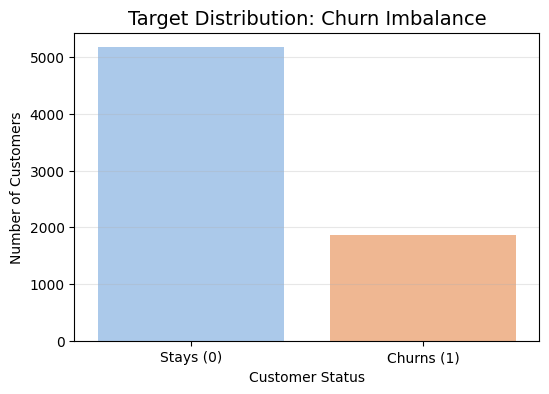


--- Analysis of Drivers ---
✅ Saved: 2_Drivers.svg


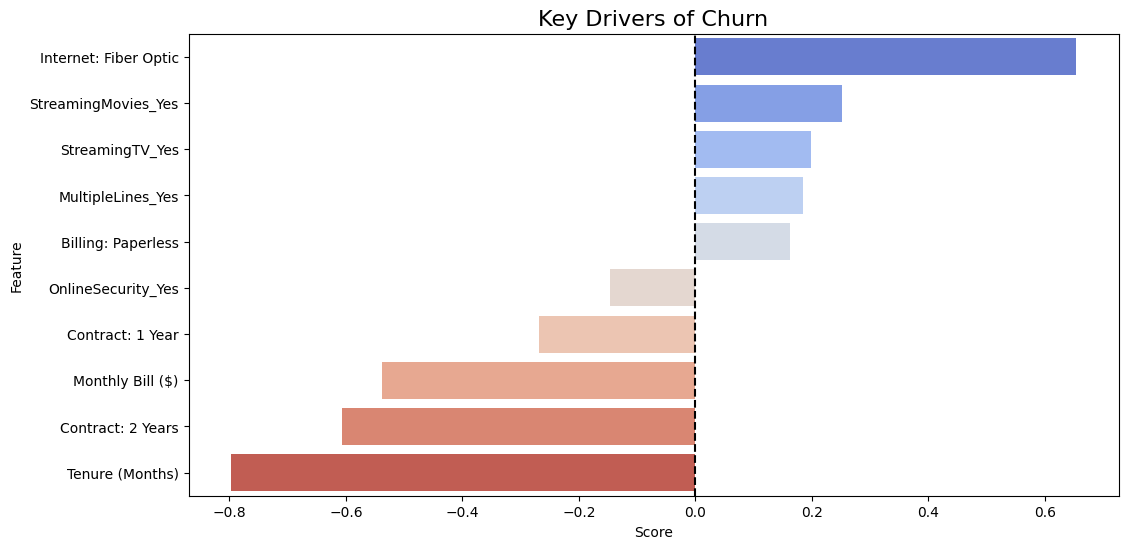

➤ Insight: Fiber Optic internet and Month-to-Month contracts are high risk.

4. MODELING
Strategy: Compare Logistic Regression, Decision Tree, and Random Forest.

✅ Models Trained Successfully.

5. EVALUATION
✅ Saved: 3_Accuracy.svg


/tmp/ipython-input-3060049777.py:162: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Model', y='Accuracy', data=results, palette='viridis')


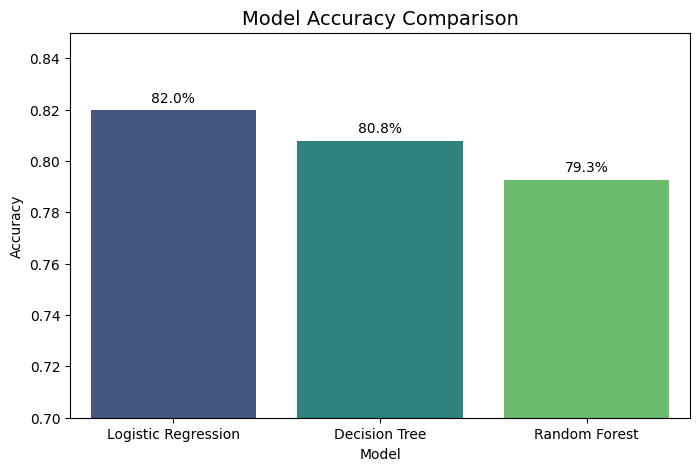


6. DEPLOYMENT & CONCLUSION
🏆 WINNER: Logistic Regression (82.0% Accuracy)
➤ Analysis: Logistic Regression performs best due to linear decision boundaries.
➤ Unsolved Challenge: Recall is lower for churners (model favors majority class).
➤ Future Work: Implement SMOTE to balance the dataset.

--- Confusion Matrix (Best Model) ---
✅ Saved: 4_ConfusionMatrix.svg


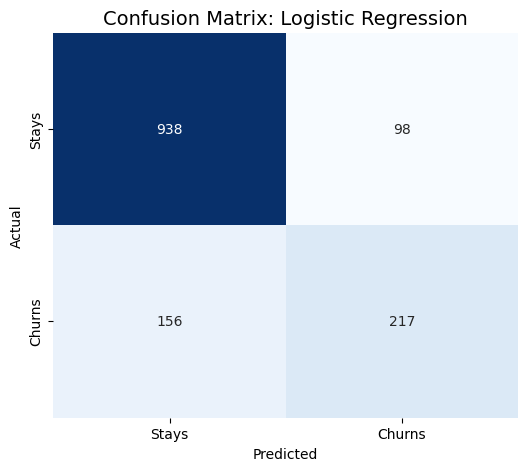

In [5]:
# ==========================================
# FINAL PROJECT: TELCO CUSTOMER CHURN
# Authors: Nitesh Kumar, Dhruv Garg, Vansh
# Version: 1.0.0
# Methodology: CRISP-DM
# ==========================================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import io

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Preprocessing & Metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ==========================================
# 1. BUSINESS UNDERSTANDING & DATA LOADING
# ==========================================
print("\n" + "="*40)
print("1. BUSINESS UNDERSTANDING & DATA LOADING")
print("="*40)
print("Goal: Predict customer churn to improve retention.")
print("Success Criteria: Accuracy > 80%.\n")

# FILE UPLOAD HANDLING
try:
    df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
    print(f"✅ Dataset Loaded Locally: {len(df)} records")
except FileNotFoundError:
    print("⚠️ File not found locally. Please upload 'WA_Fn-UseC_-Telco-Customer-Churn.csv' now...")
    from google.colab import files
    uploaded = files.upload()
    file_name = list(uploaded.keys())[0]
    df = pd.read_csv(io.BytesIO(uploaded[file_name]))
    print(f"✅ Dataset Uploaded & Loaded: {len(df)} records")

# ==========================================
# 2. DATA PREPARATION
# ==========================================
print("\n" + "="*40)
print("2. DATA PREPARATION")
print("="*40)
print("Challenges: 'TotalCharges' was text; categorical variables needed encoding.")
print("Solution: Coerced errors to numbers, filled missing values, applied One-Hot Encoding.\n")

# Clean Numeric Data
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True)

# Encode Target
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Feature Engineering
y = df['Churn']
X = df.drop(['Churn', 'customerID'], axis=1)
X = pd.get_dummies(X, drop_first=True)
X_final = X.drop(['TotalCharges'], axis=1, errors='ignore')

# Split and Scale
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Data Processed & Scaled (80% Train / 20% Test).")

# ==========================================
# 3. DATA UNDERSTANDING (EDA)
# ==========================================
print("\n" + "="*40)
print("3. DATA UNDERSTANDING (VISUALIZATION)")
print("="*40)

plt.figure(figsize=(6, 4))
sns.countplot(x=df['Churn'], palette='pastel')
plt.title('Target Distribution: Churn Imbalance', fontsize=14)
plt.xlabel('Customer Status')
plt.xticks([0, 1], ['Stays (0)', 'Churns (1)'])
plt.ylabel('Number of Customers')
plt.grid(axis='y', alpha=0.3)
plt.savefig("1_Distribution.svg", format='svg', bbox_inches='tight')
print("✅ Saved: 1_Distribution.svg")
plt.show()

print("\n--- Analysis of Drivers ---")
# Interpretability Model
explainer_model = LogisticRegression(max_iter=1000, random_state=42)
explainer_model.fit(X_train_scaled, y_train)

coeffs = pd.DataFrame({'Feature': X_final.columns, 'Score': explainer_model.coef_[0]})
name_mapping = {
    'tenure': 'Tenure (Months)', 'MonthlyCharges': 'Monthly Bill ($)',
    'InternetService_Fiber optic': 'Internet: Fiber Optic',
    'Contract_Two year': 'Contract: 2 Years', 'Contract_One year': 'Contract: 1 Year',
    'PaperlessBilling_Yes': 'Billing: Paperless'
}
coeffs['Feature'] = coeffs['Feature'].replace(name_mapping)
coeffs = coeffs.sort_values(by='Score', ascending=False)
plot_data = pd.concat([coeffs.head(5), coeffs.tail(5)])

plt.figure(figsize=(12, 6))
sns.barplot(x='Score', y='Feature', data=plot_data, hue='Feature', palette='coolwarm', legend=False)
plt.title('Key Drivers of Churn', fontsize=16)
plt.axvline(x=0, color='black', linestyle='--')
plt.savefig("2_Drivers.svg", format='svg', bbox_inches='tight')
print("✅ Saved: 2_Drivers.svg")
plt.show()

print("➤ Insight: Fiber Optic internet and Month-to-Month contracts are high risk.")

# ==========================================
# 4. MODELING
# ==========================================
print("\n" + "="*40)
print("4. MODELING")
print("="*40)
print("Strategy: Compare Logistic Regression, Decision Tree, and Random Forest.\n")

# Logistic Regression
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train_scaled, y_train)
log_pred = log_model.predict(X_test_scaled)

# Decision Tree
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train_scaled, y_train)
dt_pred = dt_model.predict(X_test_scaled)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)

print("✅ Models Trained Successfully.")

# ==========================================
# 5. EVALUATION
# ==========================================
print("\n" + "="*40)
print("5. EVALUATION")
print("="*40)

log_acc = accuracy_score(y_test, log_pred)
dt_acc = accuracy_score(y_test, dt_pred)
rf_acc = accuracy_score(y_test, rf_pred)

results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest'],
    'Accuracy': [log_acc, dt_acc, rf_acc]
})
results = results.sort_values(by='Accuracy', ascending=False)

plt.figure(figsize=(8, 5))
bar_plot = sns.barplot(x='Model', y='Accuracy', data=results, palette='viridis')
plt.title('Model Accuracy Comparison', fontsize=14)
plt.ylim(0.70, 0.85)
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height():.1%}',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.savefig("3_Accuracy.svg", format='svg', bbox_inches='tight')
print("✅ Saved: 3_Accuracy.svg")
plt.show()

# ==========================================
# 6. DEPLOYMENT & CONCLUSION
# ==========================================
print("\n" + "="*40)
print("6. DEPLOYMENT & CONCLUSION")
print("="*40)

best_model = results.iloc[0]['Model']
print(f"🏆 WINNER: {best_model} ({results.iloc[0]['Accuracy']:.1%} Accuracy)")
print("➤ Analysis: Logistic Regression performs best due to linear decision boundaries.")
print("➤ Unsolved Challenge: Recall is lower for churners (model favors majority class).")
print("➤ Future Work: Implement SMOTE to balance the dataset.")

print("\n--- Confusion Matrix (Best Model) ---")
cm = confusion_matrix(y_test, log_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Stays', 'Churns'], yticklabels=['Stays', 'Churns'])
plt.title(f'Confusion Matrix: {best_model}', fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig("4_ConfusionMatrix.svg", format='svg', bbox_inches='tight')
print("✅ Saved: 4_ConfusionMatrix.svg")
plt.show()